In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse, add_self_loops, get_laplacian

In [2]:
Traffic = pd.read_csv("data/traffic.csv")
Adjacency = np.load('data/Adjacency.npy')

In [4]:
Traffic.head()

,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


In [5]:
Adjacency

array([[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [  0. ,   0. , 371.6, ...,   0. ,   0. ,   0. ],
       [  0. , 371.6,   0. , ...,   0. ,   0. ,   0. ],
       ...,
       [  0. ,   0. ,   0. , ...,   0. , 172.4,   0. ],
       [  0. ,   0. ,   0. , ..., 172.4,   0. ,   0. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]])

In [3]:
# Assume that each time step contains data for all locations
features = torch.tensor(Traffic[['occupy', 'speed']].values, dtype=torch.float)
num_nodes = features.shape[0]  # Get the number of nodes

# Convert adjacency matrix to PyTorch tensor format
adj_matrix = torch.tensor(Adjacency, dtype=torch.float)
adj_matrix += torch.eye(adj_matrix.size(0))


degree_matrix = adj_matrix.sum(dim=1)
# D^(-1/2)
d_inv_sqrt = torch.diag(degree_matrix.pow(-0.5))
# D^(-1/2) * A * D^(-1/2)
adj_matrix_norm = d_inv_sqrt @ adj_matrix @ d_inv_sqrt

edge_index, edge_weight = dense_to_sparse(adj_matrix_norm)

# edge_index, edge_weight = dense_to_sparse(adj_matrix)
# # D^-1/2 A D^-1/2
# edge_index, edge_weight = get_laplacian(edge_index, edge_weight, normalization="sym")

# Prepare time step features and labels
node_features_per_time = []
labels_per_time = []

# Count all time steps
time_steps = Traffic['timestep'].nunique()
num_locations = Traffic['location'].nunique()

# Calculate the mean and standard deviation of features and labels
all_features = torch.tensor(Traffic[['occupy', 'speed']].values, dtype=torch.float)
feature_mean = all_features.mean(dim=0)
feature_std = all_features.std(dim=0)

all_labels = torch.tensor(Traffic['flow'].values, dtype=torch.float)
label_mean = all_labels.mean()
label_std = all_labels.std()

In [4]:
# Process data at each time step
for timestep in range(1, time_steps + 1):
    
    timestep_data = Traffic[Traffic['timestep'] == timestep]
    features = torch.tensor(timestep_data[['occupy', 'speed']].values, dtype=torch.float)
    labels = torch.tensor(timestep_data['flow'].values, dtype=torch.float)

    # Standardized features and labels
    features = (features - feature_mean) / feature_std
    labels = (labels - label_mean) / label_std

    node_features_per_time.append(features)
    labels_per_time.append(labels)

In [ ]:
class SpatioTemporalGNN(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):

        super(SpatioTemporalGNN, self).__init__()
        # Spatial
        self.gcn = GCNConv(in_channels, hidden_channels, add_self_loops=None, normalize=False)
        # Temporal
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        # Output, hidden feature project to output dimension
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):

        # x shape:(batch_size, time_steps, num_nodes, in_channels)
        batch_size, time_steps, num_nodes, in_channels = x.size()
        outputs = []

        # Compute edge_index_batch and edge_weight_batch once, outside the time loop
        edge_index_batch, edge_weight_batch = self._batch_edge_index(
            edge_index, edge_weight, num_nodes, batch_size
        )

        for t in range(time_steps):

            # Extract node features at the current time step
            x_t = x[:, t, :, :]  # Shape:(batch_size, num_nodes, in_channels)
            # Reshape data into a shape suitable for GCN input
            x_t = x_t.view(batch_size * num_nodes, in_channels)
            # Spatial feature extraction through GCN layer and applying ReLU activation function
            x_t = torch.relu(self.gcn(x_t, edge_index_batch, edge_weight_batch))
            # Reshape data back to (batch_size, num_nodes, hidden_channels)
            x_t = x_t.view(batch_size, num_nodes, -1)
            # Add the output of the current time step to the outputs list
            outputs.append(x_t)

        # Stack the outputs of all time steps to form: (batch_size, time_steps, num_nodes, hidden_channels)
        x = torch.stack(outputs, dim=1)
        # LSTM layer reshape data, the shape is: (batch_size * num_nodes, time_steps, hidden_channels)
        x = x.view(batch_size * num_nodes, time_steps, -1)
        # Temporal feature extraction through LSTM layer
        x, _ = self.lstm(x)
        # Take the output of the last time step of LSTM
        x = x[:, -1, :]
        # Reshape data back to (batch_size, num_nodes, hidden_channels)
        x = x.view(batch_size, num_nodes, -1)
        # Obtain the final prediction output through the fully connected layer
        x = self.fc(x)

        return x

    def _batch_edge_index(self, edge_index, edge_weight, num_nodes, batch_size):

        # The initialization list is used to store the edge_index and edge_weight of the batch.
        edge_indices = []
        edge_weights = []

        # Iterate through each graph in the batch
        for i in range(batch_size):
            
            offset = i * num_nodes  # Calculate the offset of the node index
            # Adjust edge_index to fit the batch, adding the node index plus the offset
            edge_indices.append(edge_index + offset)
            # Copy edge_weight since the topology of each graph is the same
            edge_weights.append(edge_weight)
            
        # Concatenate the edge_index and edge_weight of all graphs in dimension 1
        edge_index_batch = torch.cat(edge_indices, dim=1)
        edge_weight_batch = torch.cat(edge_weights)
        
        return edge_index_batch, edge_weight_batch

In [8]:
# stack to a tensor
node_features = torch.stack(node_features_per_time)  # [time_steps, num_nodes, num_features]
labels = torch.stack(labels_per_time)  # [time_steps, num_nodes]

# add batch and dimension
node_features = node_features.unsqueeze(0)  # (1, time_steps, num_nodes, num_features)
labels = labels.unsqueeze(0).unsqueeze(-1)  # (1, time_steps, num_nodes, 1)

in_channels = node_features.shape[3]
hidden_channels = 16
out_channels = 1
model = SpatioTemporalGNN(in_channels, hidden_channels, out_channels)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100

# make sure shape of label
labels = labels.unsqueeze(0).unsqueeze(-1)  # Shape:(1, time_steps, num_nodes, 1)

# 測試

In [51]:
import matplotlib.pyplot as plt

node_idx = 10
time_steps_to_display = 100

losses = []
predicted_values_per_time_step = []
    
for epoch in range(epochs):

    optimizer.zero_grad()
    # Forward pass
    output = model(node_features, edge_index, edge_weight)  # Shape: (1, num_nodes, out_channels)

    # Compute loss
    loss = loss_fn(output.squeeze(), labels[:, -1, :, :].squeeze())
    loss.backward()
    optimizer.step()

    # Record loss
    losses.append(loss.item())

    # De-standardize predictions to compare with actual values
    predicted = output.squeeze().detach().cpu().numpy()
    predicted_actual = (predicted * label_std.item()) + label_mean.item()
    predicted_values_per_time_step.append(predicted_actual)

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.0017
Epoch 2, Loss: 0.9994
Epoch 3, Loss: 0.9964
Epoch 4, Loss: 0.9944
Epoch 5, Loss: 0.9934
Epoch 6, Loss: 0.9913
Epoch 7, Loss: 0.9892
Epoch 8, Loss: 0.9881
Epoch 9, Loss: 0.9867
Epoch 10, Loss: 0.9854
Epoch 11, Loss: 0.9841
Epoch 12, Loss: 0.9811
Epoch 13, Loss: 0.9784
Epoch 14, Loss: 0.9747
Epoch 15, Loss: 0.9715
Epoch 16, Loss: 0.9680
Epoch 17, Loss: 0.9638
Epoch 18, Loss: 0.9598
Epoch 19, Loss: 0.9568
Epoch 20, Loss: 0.9593
Epoch 21, Loss: 0.9574
Epoch 22, Loss: 0.9514
Epoch 23, Loss: 0.9532
Epoch 24, Loss: 0.9534
Epoch 25, Loss: 0.9508
Epoch 26, Loss: 0.9500
Epoch 27, Loss: 0.9499
Epoch 28, Loss: 0.9480
Epoch 29, Loss: 0.9464
Epoch 30, Loss: 0.9460
Epoch 31, Loss: 0.9440
Epoch 32, Loss: 0.9429
Epoch 33, Loss: 0.9419
Epoch 34, Loss: 0.9399
Epoch 35, Loss: 0.9392
Epoch 36, Loss: 0.9379
Epoch 37, Loss: 0.9360
Epoch 38, Loss: 0.9350
Epoch 39, Loss: 0.9331
Epoch 40, Loss: 0.9317
Epoch 41, Loss: 0.9300
Epoch 42, Loss: 0.9283
Epoch 43, Loss: 0.9268
Epoch 44, Loss: 0.92

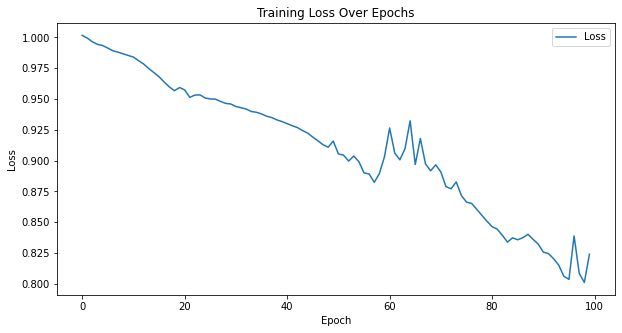

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

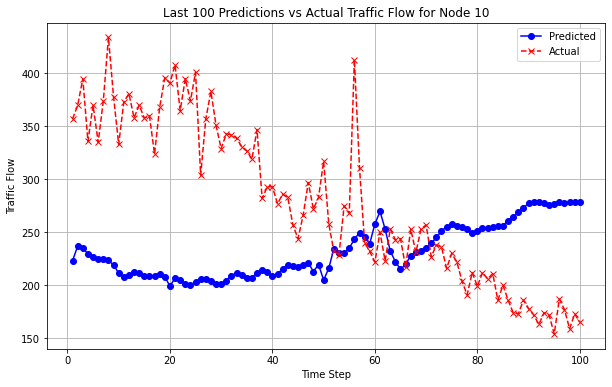

In [53]:
last_time_steps_predictions = [predicted[node_idx] for predicted in predicted_values_per_time_step[-time_steps_to_display:]]
# De-standardize the actual values to get the true traffic flow values
last_time_steps_actuals = labels[0, 0, -time_steps_to_display:, node_idx, 0, 0].cpu().numpy()
last_time_steps_actuals = (last_time_steps_actuals * label_std.item()) + label_mean.item()  # Convert back to actual values

# Plot predicted vs actual traffic flow values
plt.figure(figsize=(10, 6))
plt.plot(range(1, time_steps_to_display + 1), last_time_steps_predictions, marker='o', linestyle='-', color='b', label="Predicted")
plt.plot(range(1, time_steps_to_display + 1), last_time_steps_actuals, marker='x', linestyle='--', color='r', label="Actual")
plt.title(f"Last {time_steps_to_display} Predictions vs Actual Traffic Flow for Node {node_idx}")
plt.xlabel("Time Step")
plt.ylabel("Traffic Flow")
plt.legend()
plt.grid()
plt.show()

In [54]:
import numpy as np

mae_values = []
rmse_values = []
mape_values = []

# predicted_values_actual_scale = [(pred * label_std.item()) + label_mean.item() for pred in predicted_values_per_time_step]
predicted_node_values_actual_scale = [pred[node_idx] for pred in predicted_values_per_time_step[-time_steps_to_display:]]
actual_node_values_actual_scale = (labels[0, 0, -time_steps_to_display:, node_idx, 0, 0].cpu().numpy() * label_std.item()) + label_mean.item()

# Calculate MAE
mae = np.mean(np.abs(np.array(predicted_node_values_actual_scale) - actual_node_values_actual_scale))
mae_values.append(mae)

# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(predicted_node_values_actual_scale) - actual_node_values_actual_scale) ** 2))
rmse_values.append(rmse)

# Calculate MAPE (avoiding division by zero)
mape = np.mean(np.abs((np.array(predicted_node_values_actual_scale) - actual_node_values_actual_scale) / (actual_node_values_actual_scale + 1e-8))) * 100
mape_values.append(mape)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 91.2416
RMSE: 107.3602
MAPE: 32.14%
